# Contact prediction
## Notebook implements two versions of contact prediction
### 1. Categorical jacobian
### 2. ESM contact prediction 




In [1]:
import torch
import os
from protein_lm.modeling.getters.model import get_model
from protein_lm.modeling.getters.tokenizer import get_tokenizer

In [2]:
#!wget -qnc https://raw.githubusercontent.com/sokrypton/algosb_2021/main/utils.py
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from utils import *
import yaml

In [3]:
import sys
my_path = '../../configs/train/toy_localcsv.yaml'
sys.path.append(my_path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open(my_path, "r") as cf:
    config_dict = yaml.safe_load(cf)
    print(config_dict)

model = get_model(
        config_dict=config_dict["model"],
    )
tokenizer = get_tokenizer(config_dict=config_dict["tokenizer"])

{'dataset': {'dataset_type': 'csv', 'dataset_loc': 'protein_lm/dataset/uniref/uniref50_trimmed.csv', 'train_sample_size': 100, 'sequence_column_name': 'sequence', 'max_sequence_length': 10}, 'training_args': {'output_dir': 'checkpoints/toy', 'max_steps': 1, 'num_train_epochs': 1, 'learning_rate': 0.1, 'weight_decay': 0.1, 'save_strategy': 'epoch', 'per_device_train_batch_size': 1, 'save_steps': 1, 'report_to': 'none', 'label_names': ['labels'], 'no_cuda': False}, 'tokenizer': {'tokenizer_type': 'APT'}, 'model': {'nn_model_type': 'APT', 'nn_model_config_args': {'position_embedding': 'learned', 'max_sequence_length': 10}, 'pretrained_checkpoint': None}, 'data_collator': {'data_collator_type': 'default'}}


### Download data

In [4]:
!wget -qnc https://files.ipd.uw.edu/krypton/RL29.uni.1e-10.i8.i90c75.a3m
headers, seqs = parse_fasta("RL29.uni.1e-10.i8.i90c75.a3m", a3m = True)

# # Download MSAs from esm example repo
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1a3a_1_A.a3m
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/5ahw_1_A.a3m
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1xcr_1_A.a3m


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0   919k      0 --:--:-- --:--:-- --:--:--  919k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   603k      0 --:--:-- --:--:-- --:--:--  603k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181k  100  181k    0     0  1030k      0 --:--:-- --:--:-- --:--:-- 1030k


### Compute categorical jacobian

In [5]:
def get_categorical_jacobian(seq):
  # ∂in/∂out
    x,ln = tokenizer.encode(seq),len(seq)
    x=torch.tensor(x)
    with torch.no_grad():
        #model.logits returns batch_size x seq_len x vocab_size tensor
        f = lambda x: model(x.to(device)).logits[...,:,3:23].cpu().numpy()
        fx = f(x.to(device))[0]
        x = torch.tile(x,[20,1]).to(device)
        fx_h = np.zeros((ln,20,ln,20))
        for n in range(ln-1): # for each position
          x_h = torch.clone(x)
          x_h[:,n] = torch.arange(3,23) # mutate to all 20 aa
          fx_h[n] = f(x_h)
        return fx-fx_h

In [6]:
print(seqs[0])
jac = get_categorical_jacobian(seqs[1])
# center & symmetrize
for i in range(4): jac -= jac.mean(i,keepdims=True)
jac = (jac + jac.transpose(2,3,0,1))/2

MKAKELREKSVEELNTELLNLLREQFNLRMQAASGQLQQSHLLKQVRRDVARVKTLLNEKAGA


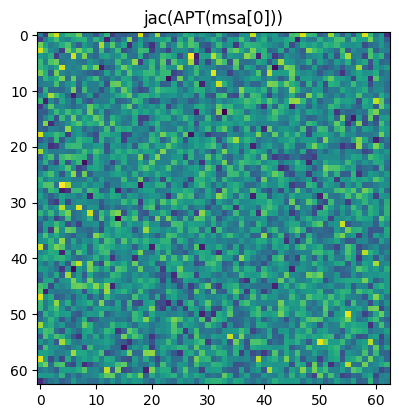

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2); plt.title("jac(APT(msa[0]))"); plt.imshow(get_contacts(jac))
plt.show()

# ESM predict contacts

### Imports
#### Users may need to install biotite 

In [8]:
import torch
from protein_lm.modeling.models.apt.model_pytorch import APTLMHeadModel
from protein_lm.modeling.models.apt.config import APTConfig
from protein_lm.tokenizer.tokenizer import AptTokenizer

from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd
torch.set_grad_enabled(False)

### Utility functions

In [9]:

deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)


def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Convert structures to contacts

In [10]:

def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))

    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts


### Subsampling MSA

In [11]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Compute contact precisions

In [12]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [13]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    #print(seqlen)
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    #print(relative_distance)
    bottom_mask = relative_distance < 0

    predictions=np.squeeze(predictions)
    masked_image = np.ma.masked_where(bottom_mask,predictions)

    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]

    pred_contacts = predictions >= topl_val
    #print(pred_contacts)
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None
    # Adjust the printing options to display the complete array
    #print("s")

    np.set_printoptions(threshold=np.inf)

    # Print the array

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

### Import model

In [14]:
config = APTConfig()
config.attention_mode="APT"
config.position_embedding = "learned"


model = APTLMHeadModel(config=config)
tokenizer = AptTokenizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"{name.lower()}_1_A.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()}

### Predict contacts

In [16]:
if torch.cuda.is_available():
    model.cuda()

apt_predictions = {}
apt_results = []

with torch.no_grad():
  for name, inputs in sequences.items():

      token_ids = tokenizer.encode(inputs[1])

      token_ids = torch.tensor(token_ids, dtype=torch.long)
      token_ids = token_ids.to(device)  # Move token_ids to the same device as the model

      token_ids=token_ids.unsqueeze(0)
      apt_predictions[name] = model.predict_contacts(token_ids)
      metrics = {"id": name, "model": "APT(Unsupervised)"}
      metrics.update(evaluate_prediction(apt_predictions[name], contacts[name]))
      apt_results.append(metrics)
apt_results = pd.DataFrame(apt_results)
display(apt_results)


,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,APT(Unsupervised),0.292581,0.289655,0.263889,0.344828,0.079166,0.068966,0.069444,0.103448,0.027358,0.041379,0.027778,0.00,0.048703,0.041379,0.069444,0.034483
1,5ahw,APT(Unsupervised),0.321466,0.328000,0.306452,0.400000,0.061142,0.048000,0.048387,0.120000,0.032958,0.032000,0.032258,0.04,0.067984,0.056000,0.080645,0.080000
2,1xcr,APT(Unsupervised),0.181610,0.146965,0.160256,0.225806,0.039403,0.028754,0.044872,0.064516,0.020100,0.022364,0.025641,0.00,0.005575,0.006390,0.006410,0.000000


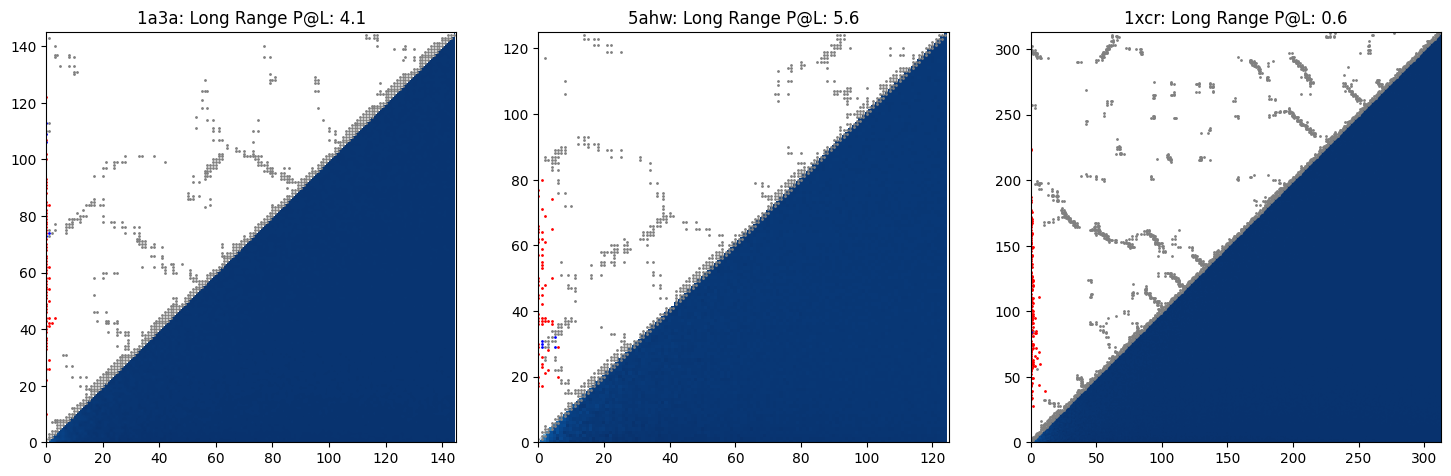

In [17]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = apt_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()